In [1]:
# import packages
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from bt_classes import my_backtest, test_indicator
# orig_df = pd.read_csv('../res/test_data.csv',index_col=0,parse_dates=True)
# my_backtest(orig_df[:500])
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
rcParams['figure.figsize'] = 20,10
# df = pd.read_csv('../res/input0130.csv')

orig_df = pd.read_csv('../xau_1d_20y.csv')
orig_df['datetime'] = pd.to_datetime(orig_df['date'])
orig_df = orig_df.set_index('datetime')

df = orig_df.copy()
df['log_r'] = np.log(df['close']) - np.log(df['open'])
df['label'] = np.sign(df['log_r'].shift(-1))
df['label'][df['label']==-1] = 0
df['label'].fillna(0,inplace=True)

## Train model

In [2]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
# follow the literature
# we don't use min-max scaling here, use partial mean-std scaling instead
from sklearn.preprocessing import StandardScaler
from itertools import chain

# and we define our model here
def lstm_model(sample_len=240,para_a=42, para_b=17):
    model = Sequential()
    model.add(LSTM(units=para_a, dropout=0.1, return_sequences=True, input_shape=(sample_len,1),activation='tanh'))# (25,15)-57, (42,17)-58
    model.add(LSTM(units=para_b, dropout=0.08, activation='tanh'))
    # model.add(Dropout(0.08))# 加了之后同原先效果差不多，（应该一定程度上）可以防止过拟合
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [3]:
sample_len = 60
train_begin = sample_len
train_end = train_begin + 2000
scaler = StandardScaler()
train_set = df[['log_r','label']][train_begin-sample_len:train_end].reset_index()
x_train, y_train = [], []
x_train_set = list(chain.from_iterable(scaler.fit_transform(train_set['log_r'].values.reshape(-1,1))))
for i in range(sample_len,len(x_train_set)):
    x_train.append(x_train_set[i-sample_len:i])
    y_train.append(train_set['label'][i])
x_train, y_train = np.array(x_train), np.array(y_train)
y_train = to_categorical(y_train,2)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

model = lstm_model(sample_len=sample_len)
model.fit(x_train,y_train,epochs=30, batch_size=100, callbacks=[EarlyStopping(monitor='loss',patience=10)])


Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5285
Epoch 2/30
2000/2000 [==============================] - 2s 948us/step - loss: 0.6913 - accuracy: 0.5215
Epoch 3/30
2000/2000 [==============================] - 2s 963us/step - loss: 0.6917 - accuracy: 0.5235
Epoch 4/30
2000/2000 [==============================] - 2s 948us/step - loss: 0.6912 - accuracy: 0.5225
Epoch 5/30
2000/2000 [==============================] - 2s 955us/step - loss: 0.6912 - accuracy: 0.5245
Epoch 6/30
2000/2000 [==============================] - 2s 986us/step - loss: 0.6918 - accuracy: 0.5210
Epoch 7/30
2000/2000 [==============================] - 2s 960us/step - loss: 0.6907 - accuracy: 0.5230
Epoch 8/30
2000/2000 [==============================] - 2s 937us/step - loss: 0.6918 - accuracy: 0.5245
Epoch 9/30
2000/2000 [==============================] - 2s 958us/step - loss: 0.6904 - accuracy: 0.5305
Epoch 10/30
2000/2000 [==============================] - 2s 952us

In [4]:
model.save('d60-2060.h5')  # d日频，240-2240天

## Get test set

In [4]:
from keras.models import load_model
model = load_model('d240-2240.h5')  

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 42)            7392      
_________________________________________________________________
lstm_2 (LSTM)                (None, 17)                4080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36        
Total params: 11,508
Trainable params: 11,508
Non-trainable params: 0
_________________________________________________________________


In [6]:
from tqdm import tqdm
from sa import *
from utils import *

# Please select the last activation layer.
layer_names = ['lstm_2']

default_upper_bound = 2000
default_n_bucket = 1000
default_n_classes = 2
class Args(): #创建一个类
    def __init__(self): #定义初始化信息。
        self.is_classification = True
        self.save_path = None
        self.d = 'lstm_r'
        self.num_classes = 2
        self.lsa = True
        self.dsa = True
        self.target = 'none'
        self.batch_size = 128
        self.var_threshold = 1e-5
        self.upper_bound = 2000
        self.n_bucket = 1000
        self.is_classification = True
args = Args()

In [10]:
test_len = 250
step = 25
starter = range(2060,len(df)-test_len,step)
all_results = []
layer_names = ['lstm_2']
for test_begin in starter:
    test_end = test_begin + test_len

    x_test, y_test = [], []
    test_set = df[['log_r','label']][test_begin-sample_len:test_end].reset_index()
    y_true = df['label'][test_begin:test_end]
    x_test_set = list(chain.from_iterable(scaler.transform(test_set['log_r'].values.reshape(-1,1))))
    for i in range(sample_len,len(x_test_set)):
        x_test.append(x_test_set[i-sample_len:i])
        y_test.append(test_set['label'][i])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 
    y_test = to_categorical(y_test,2)

    y_pred = model.predict_classes(x_test)

    ti = test_indicator(y_true,y_pred)
    # to_save = pd.DataFrame()
    # to_save['y_true'] = y_true
    # to_save['y_pred'] = y_pred
    # to_save.to_csv(f'{test_begin}_{test_end}_test.csv')
    test_dsa = fetch_dsa(model, x_train, x_test, 'dsa from{}'.format(test_begin), layer_names, args)
    dsa_cov = get_sc(np.amin(test_dsa), 5, 20, test_dsa)
    test_lsa = fetch_lsa(model, x_train, x_test, 'lsa from{}'.format(test_begin), layer_names, args)
    lsa_cov = get_sc(np.amin(test_lsa), 1500, 20, test_lsa)
    eva = model.evaluate(x_test, y_test)
    mark = pd.DataFrame()
    mark['y_true'] = y_true
    mark['y_pred'] = y_pred
    mark['win'] = 0
    mark['win'].loc[mark['y_true']==mark['y_pred']] = 1
    mark['lsa'] = test_lsa
    mark['dsa'] = test_dsa
    lsa_win_pearson = mark[['win','lsa']].corr().iloc[0,1]
    lsa_win_spearman = mark[['win','lsa']].corr(method='spearman').iloc[0,1]
    dsa_win_pearson = mark[['win','dsa']].corr().iloc[0,1]
    dsa_win_spearman = mark[['win','dsa']].corr(method='spearman').iloc[0,1]
    print('Loss: {:.2f}, Accuracy: {:.2f}'.format(eva[0], eva[1]))
    print('Dsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa)))
    print('Lsa Mean: {:.2f}, Var: {:.2f}, Max: {:.2f}, Min: {:.2f}'.format(np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa)))
    test_df = orig_df[test_begin:test_end]
    test_df['label'] = model.predict_classes(x_test)
    sharpe,dd,ar = my_backtest(test_df)
    this_result = [test_begin,test_end,eva[0],eva[1],ti.get_precision(),ti.get_recall(),ti.get_successive_n_failure_rate(),dsa_cov,np.mean(test_dsa),np.std(test_dsa),np.max(test_dsa),np.min(test_dsa),lsa_cov,np.mean(test_lsa),np.std(test_lsa),np.max(test_lsa),np.min(test_lsa),sharpe,dd,ar,lsa_win_pearson,dsa_win_pearson,lsa_win_spearman,dsa_win_spearman]
    all_results.append(this_result)
    rs = pd.DataFrame(all_results,columns=['test_begin','test_end','loss','accuracy','precision','recall','snfr','dsa_cov','dsa_mean','dsa_std','dsa_max','dsa_min','lsa_cov','lsa_mean','lsa_std','lsa_max','lsa_min','sharpe','drawdown','annual','lsa_win_pearson','dsa_win_pearson','lsa_win_spearman','dsa_win_spearman'])
    rs.to_csv(f'new_rs_{sample_len}.csv')

 of removed columns: 0
[lsa from3035] Fetching LSA
250/250 [==============================] - 0s 2ms/step
Loss: 0.70, Accuracy: 0.52
Dsa Mean: 3.41, Var: 3.07, Max: 26.04, Min: 0.93
Lsa Mean: 39530.70, Var: 64401.63, Max: 567398.17, Min: 1232.04
Starting Portfolio Value: 100000.00
Final Portfolio Value: 78445.00
Sharpe: -0.40
Max drawdown: 36.94%
Annual rate: -21.71%
Found saved train ATs, skip serving
[dsa from3060] Model serving
100%|██████████| 250/250 [00:00<00:00, 2106.82it/s][dsa from3060] Processing ATs
Layer: lstm_2
dsa from3060 ATs is saved at ./tmp/lstm_r_dsa from3060_lstm_2_ats.npy
[dsa from3060] Fetching DSA
Found saved train ATs, skip serving

[lsa from3060] Model serving
100%|██████████| 250/250 [00:00<00:00, 2666.67it/s][lsa from3060] Processing ATs
Layer: lstm_2
lsa from3060 ATs is saved at ./tmp/lstm_r_lsa from3060_lstm_2_ats.npy
The number of removed columns: 0
[lsa from3060] Fetching LSA
250/250 [==============================] - 0s 2ms/step
Loss: 0.69, Accuracy: 0.5

KeyboardInterrupt: 

In [11]:
rs

,test_begin,test_end,loss,accuracy,precision,recall,snfr,dsa_cov,dsa_mean,dsa_std,...,lsa_std,lsa_max,lsa_min,sharpe,drawdown,annual,lsa_win_pearson,dsa_win_pearson,lsa_win_spearman,dsa_win_spearman
0,2060,2310,0.730809,0.468,0.484018,0.841270,0.064516,100.0,3.853172,3.713922,...,65327.415627,451577.152354,537.797852,-1.336270,41.090306,-35.120154,0.015868,-0.103402,-0.039045,-0.118578
1,2085,2335,0.717780,0.492,0.507177,0.815385,0.065574,100.0,4.396459,4.702884,...,90037.911949,621970.190808,537.797852,-0.481911,42.304529,-18.323308,0.100473,-0.045241,0.026109,-0.059369
2,2110,2360,0.716960,0.488,0.497585,0.811024,0.048387,100.0,4.364895,4.751481,...,90036.720444,621970.190808,537.797852,-0.467003,42.554309,-19.097186,0.102209,-0.018248,0.032267,-0.048789
3,2135,2385,0.715944,0.492,0.497561,0.809524,0.030769,90.0,4.457242,4.736847,...,89568.115511,621970.190808,1825.035480,-0.201177,42.072000,-11.879490,0.099272,-0.009426,0.030433,0.005266
4,2160,2410,0.708383,0.524,0.507538,0.827869,0.031746,90.0,4.747425,4.885062,...,96422.254828,621970.190808,1825.035480,0.467990,30.348065,10.913138,0.104437,0.049775,0.039564,0.068530
5,2185,2435,0.713422,0.516,0.497512,0.833333,0.031746,90.0,4.716847,4.880716,...,96313.207579,621970.190808,1825.035480,0.305938,30.900918,5.870926,0.104625,0.054979,0.026785,0.075030
6,2210,2460,0.712981,0.520,0.502439,0.851240,0.031746,90.0,4.586108,4.763038,...,96946.234467,621970.190808,1825.035480,0.541340,30.759738,13.290139,0.101691,0.061742,0.025738,0.085425
7,2235,2485,0.710295,0.528,0.504808,0.875000,0.015625,95.0,4.487066,4.734884,...,96629.102437,621970.190808,1825.035480,0.549867,24.480390,13.149889,0.095426,0.095176,0.017875,0.120020
8,2260,2510,0.702554,0.532,0.514563,0.861789,0.015873,95.0,4.517347,4.740377,...,96148.293145,621970.190808,1825.035480,0.955835,22.027351,23.114010,0.099463,0.077950,0.038711,0.068925
9,2285,2535,0.699527,0.560,0.549763,0.885496,0.016129,95.0,4.289304,4.510635,...,96607.750650,621970.190808,1825.035480,0.821459,22.435000,18.737738,0.084659,0.061682,0.047232,0.028473


In [8]:
rs = pd.DataFrame(all_results,columns=['test_begin','test_end','loss','accuracy','precision','recall','snfr','dsa_cov','dsa_mean','dsa_std','dsa_max','dsa_min','lsa_cov','lsa_mean','lsa_std','lsa_max','lsa_min','sharpe','drawdown','annual','lsa_win_pearson','dsa_win_pearson','lsa_win_spearman','dsa_win_spearman'])
rs

,test_begin,test_end,loss,accuracy,precision,recall,snfr,dsa_cov,dsa_mean,dsa_std,dsa_max,dsa_min,lsa_cov,lsa_mean,lsa_std,lsa_max,lsa_min,sharpe,drawdown,annual
0,2240,2490,0.702323,0.484,0.484305,0.885246,0.047619,50.0,0.520874,0.437313,2.797825,0.111946,45.0,4.760112,127.730568,862.681826,-65.303071,0.453222,19.866535,9.968906
1,2265,2515,0.697622,0.496,0.497758,0.888000,0.047619,50.0,0.508540,0.444705,2.797825,0.101064,45.0,1.202599,128.938247,862.681826,-66.521019,0.883807,18.216018,20.867670
2,2290,2540,0.694223,0.508,0.513393,0.891473,0.032258,45.0,0.462194,0.402019,2.797825,0.101064,40.0,-24.583169,86.796671,624.541998,-66.754564,0.977826,13.275471,20.283170
3,2315,2565,0.688690,0.520,0.532110,0.865672,0.032258,45.0,0.471536,0.400996,2.797825,0.101064,25.0,-46.209189,39.355099,302.865768,-66.754564,1.840860,7.436622,33.738212
4,2340,2590,0.694569,0.504,0.522936,0.850746,0.032787,40.0,0.440147,0.350491,2.240028,0.097501,10.0,-55.784509,13.662699,62.778551,-66.754564,0.953521,8.823392,17.121816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,4840,5090,0.691759,0.528,0.528000,1.000000,0.030303,15.0,0.192696,0.116042,0.842770,0.075074,5.0,-65.147958,1.846642,-58.191949,-67.178282,1.340727,6.311944,18.341059
105,4865,5115,0.691235,0.528,0.530612,0.977444,0.030303,30.0,0.258526,0.230796,1.519455,0.075074,5.0,-65.185919,1.840342,-58.191949,-67.178282,1.958189,6.134702,28.195465
106,4890,5140,0.691106,0.528,0.530612,0.977444,0.031746,30.0,0.269051,0.228810,1.519455,0.075074,5.0,-65.032484,1.857006,-58.191949,-67.178282,2.043295,6.124736,30.859024
107,4915,5165,0.688220,0.544,0.546939,0.978102,0.015625,30.0,0.268713,0.228858,1.519455,0.075074,5.0,-64.931931,1.846316,-58.191949,-67.044424,1.681272,6.193446,25.115295


In [16]:
from scipy.stats import pearsonr, spearmanr
key1, key2 = 'snfr','annual'
pearsonr(rs[key1],rs[key2]),spearmanr(rs[key1],rs[key2])

((-0.3555092320261485, 0.00014851503672418543),
 SpearmanrResult(correlation=-0.28370907653550587, pvalue=0.0027939495103258714))

In [2]:
rs = pd.read_csv('new_rs.csv',index_col=0)
rs

,test_begin,test_end,loss,accuracy,precision,recall,snfr,dsa_cov,dsa_mean,dsa_std,...,lsa_std,lsa_max,lsa_min,sharpe,drawdown,annual,lsa_win_pearson,dsa_win_pearson,lsa_win_spearman,dsa_win_spearman
0,2120,2370,0.704843,0.484,0.493151,0.857143,0.067797,100.0,9.773320,8.546229,...,89475.983656,424149.745453,3130.161894,-0.615398,34.875000,-22.691068,0.025006,0.008185,0.013808,-0.003050
1,2145,2395,0.704058,0.488,0.486486,0.885246,0.067797,100.0,10.352857,8.835468,...,94021.614679,424149.745453,3130.161894,-0.010462,24.359025,-3.736095,0.044581,0.034574,0.027277,0.035926
2,2170,2420,0.702220,0.496,0.492891,0.845528,0.067797,100.0,10.121090,8.793214,...,95270.822619,424149.745453,3130.161894,0.040698,22.438935,-1.588507,0.022352,0.038853,-0.001774,0.039797
3,2195,2445,0.706417,0.488,0.481308,0.858333,0.050000,100.0,9.952644,8.887634,...,95557.292215,424149.745453,2394.715285,0.213823,22.495742,3.189711,-0.003475,0.011063,-0.035261,0.011643
4,2220,2470,0.705451,0.492,0.483412,0.850000,0.049180,100.0,9.997652,8.926486,...,95229.957652,424149.745453,2394.715285,0.164066,23.245814,1.737911,-0.016275,0.001455,-0.052717,-0.011364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,3795,4045,0.696755,0.484,0.479508,0.983193,0.059701,100.0,3.107455,2.379539,...,46511.312756,214346.304289,438.166411,-0.587311,17.504474,-11.510926,0.059818,0.104282,0.062941,0.097323
68,3820,4070,0.699277,0.480,0.475410,0.983051,0.058824,100.0,3.503282,2.341516,...,56906.532643,258240.797831,603.780821,-0.863809,18.618260,-15.806041,0.036258,0.099971,0.051588,0.105838
69,3845,4095,0.698455,0.488,0.485597,0.975207,0.058824,100.0,3.480366,2.417455,...,58600.757122,258240.797831,603.780821,-0.446809,17.578018,-8.369587,0.044678,0.087956,0.059656,0.079837
70,3870,4120,0.697802,0.484,0.481481,0.975000,0.059701,100.0,3.399141,2.506051,...,59497.483059,258240.797831,603.780821,0.218835,16.886420,3.351033,0.051816,0.097013,0.067044,0.079688


In [22]:
rs[['loss','accuracy']].corr().iloc[0,1]

-0.9377726553512

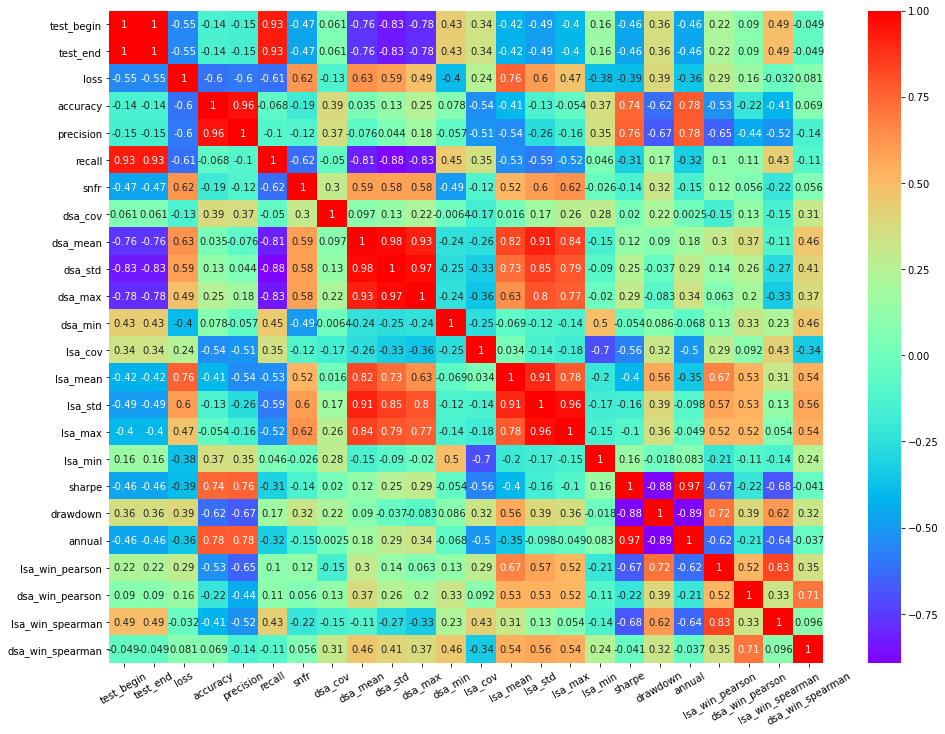

In [12]:
import seaborn as sns
plt.figure(figsize=(16,12))
sns.heatmap(rs.corr(),annot=True,cmap='rainbow')
plt.xticks(rotation=30)
plt.show()